In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms, datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

from ae_mnist import ConvAutoencoder_GELU
from utils import fgsm_attack
from lenet import Net

c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE=16
Z_DIM=10
EPS_FGSM=0.3
DATASET='mnist'

In [3]:
transform=transforms.Compose([
            transforms.ToTensor(),
])

test_dataset = datasets.MNIST(root= './data', train = False, download =True, transform = transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [5]:
classifier = Net()
classifier.to(device)
classifier.load_state_dict(torch.load('./models/lenet_mnist_model.pth'))

<All keys matched successfully>

## Confusion Matrix for Original Classifier (MNIST)

In [6]:
y_pred = []
y_true = []

In [7]:
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = classifier(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [8]:
cf_matrix = confusion_matrix(y_true, y_pred)

<AxesSubplot:>

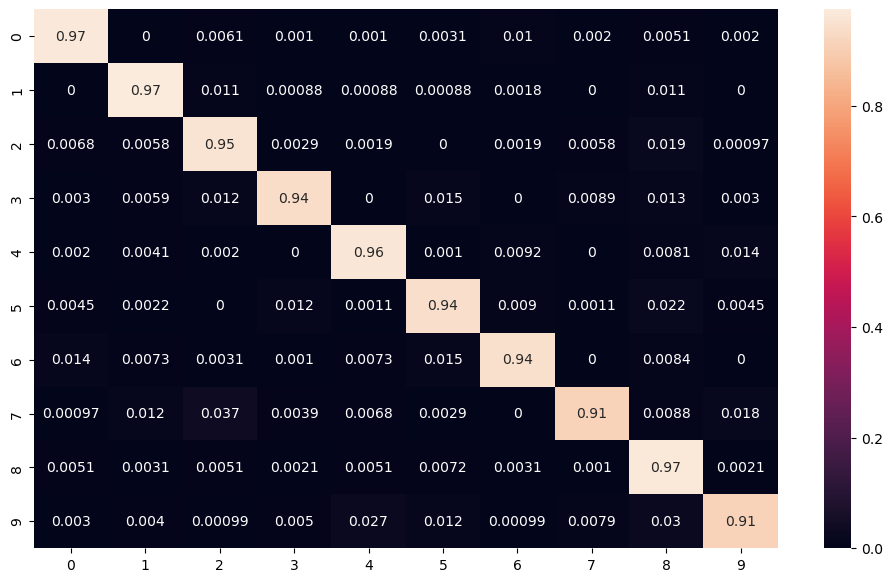

In [9]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in range(10)],
                     columns = [i for i in range(10)])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

In [16]:
fn_class = cf_matrix.sum(axis=0)

for i in range(10):
    fn_class[i] -= cf_matrix[i][i]

print(fn_class)

[ 38  44  79  28  51  56  35  27 125  44]


## Confusion Matrix After Defense Against FGSM Attack (GELU proposed)

In [17]:
include_noise = True
attack_type = 'fgsm'
activation_type = 'gelu'


if include_noise:
    file_path = f'./models/ae_mnist_{attack_type}_{activation_type}_proposed.pth.tar'
else:
    file_path = f'./models/ae_mnist_{attack_type}_{activation_type}_vanilla.pth.tar'

convAE = ConvAutoencoder_GELU(device, Z_DIM, include_noise)
convAE.to(device)
convAE.load_state_dict(torch.load(file_path)['convAE_state_dict'])

<All keys matched successfully>

In [18]:
y_pred = []
y_true = []

In [19]:
for imgs, labels in test_loader:
        imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

        adv_imgs, _ = fgsm_attack(classifier, imgs, labels, EPS_FGSM, DATASET)

        adv_imgs = adv_imgs.to(device)

        with torch.no_grad():
                rec_imgs = convAE(adv_imgs)

        output = classifier(rec_imgs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [20]:
cf_matrix = confusion_matrix(y_true, y_pred)

<AxesSubplot:>

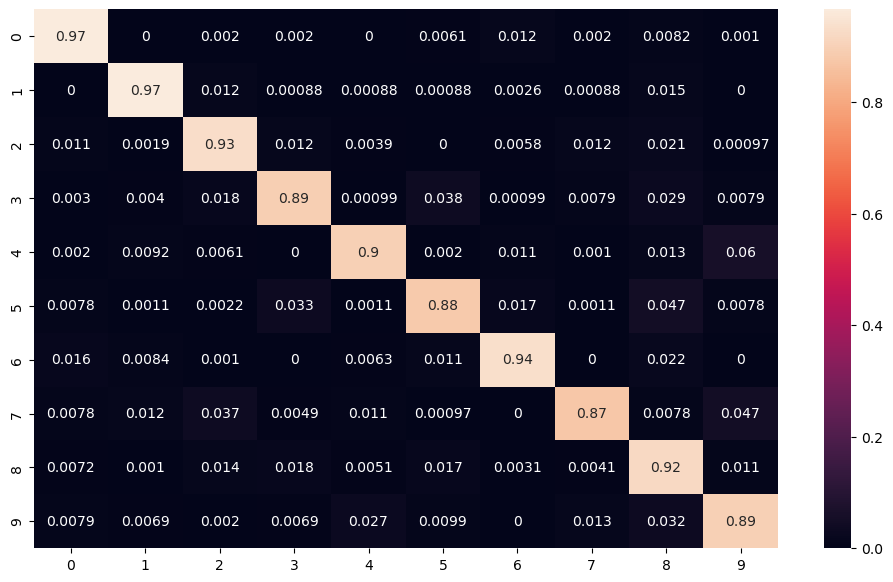

In [21]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in range(10)],
                     columns = [i for i in range(10)])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

In [22]:
fn_class = cf_matrix.sum(axis=0)

for i in range(10):
    fn_class[i] -= cf_matrix[i][i]

print(fn_class)

[ 61  44  97  74  56  86  51  42 192 135]
